# S/N and Exceedance

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import sys
import signal_to_noise as sn
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cftime

In [2]:
ROOT_DIR = '/g/data/w40/ab2313/longrunmip'

In [3]:
os.listdir(ROOT_DIR)

['tas_ann_ECHAM5MPIOM_1pct4x_6080.nc',
 'tas_mon_CCSM3_control_1530.nc',
 'tas_mon_MIROC32_control_681.nc',
 'tas_mon_CCSM3_abrupt4x_2120.nc',
 'tas_ann_FAMOUS_abrupt4x_3000_g025.nc',
 'tas_ann_ECHAM5MPIOM_control_100.nc',
 'tas_mon_MIROC32_abrupt4x_150.nc',
 'tas_mon_CCSM3_abrupt2x_3000.nc',
 'tas_mon_CCSM3_abrupt8x_1450.nc',
 'tas_mon_MIROC32_1pct4x_2002.nc',
 'tas_mon_MIROC32_1pct2x_2003.nc']

# piControl

In [4]:
control = xr.open_dataset(f'{ROOT_DIR}/tas_mon_CCSM3_control_1530.nc',
                             use_cftime = True, chunks = {'lat':100,'lon':100})

In [5]:
control = control.resample(time = 'Y').mean(dim = 'time')

In [8]:
control_climatology = sn.climatology(control, 
                                         start = control.time.dt.year.values[0]
                                        ,end = control.time.dt.year.values[-1])

In [9]:
control_climatology

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Data variables:
    tas      (lat, lon) float32 dask.array<chunksize=(48, 96), meta=np.ndarray>

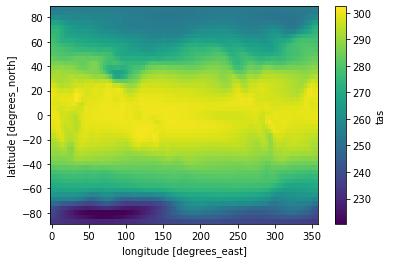

In [10]:
control_climatology.tas.plot()

In [11]:
control_anomaly = control - control_climatology

In [12]:
control_anomaly

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 96, time: 1531)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1531-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 48, 96), meta=np.ndarray>

In [13]:
control_anomaly_smean = sn.space_mean(control_anomaly)

## SN Control
The signal to noist of the control. his defines the bounds of what is considered unstable and what is not unstable.

In [14]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/signal_to_noise.py'>

In [15]:
control_anomaly_smean = control_anomaly_smean.load()

In [16]:
control_sn = (sn.sn_grad_loess(control_anomaly_smean)).squeeze()

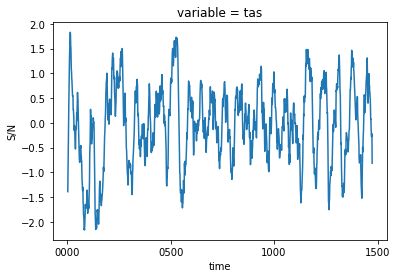

In [17]:
control_sn.plot()

(-729271.0, -170821.0)

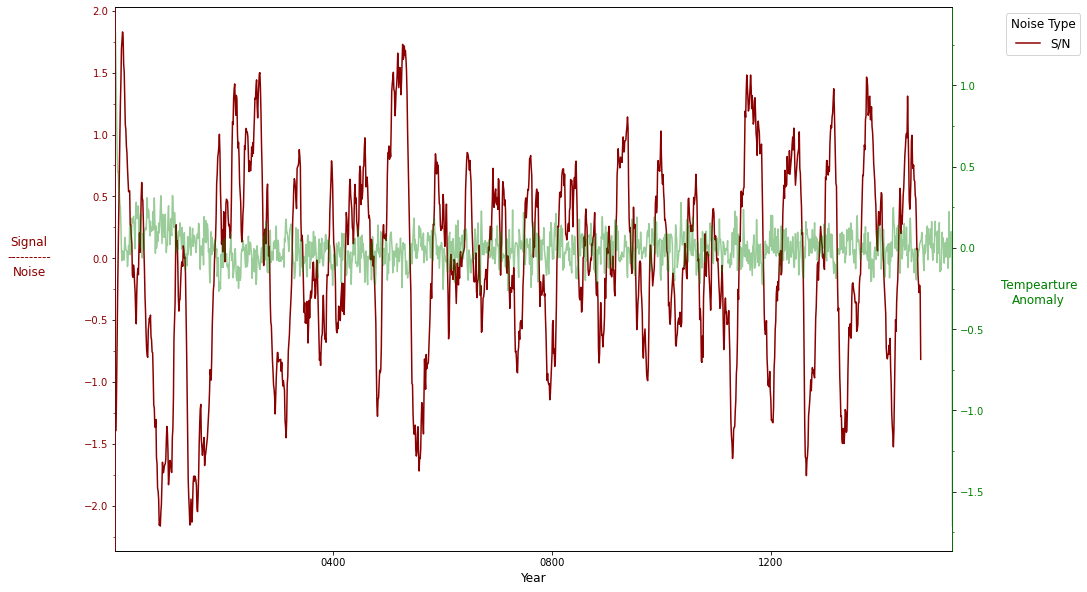

In [18]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

time =  control_sn.time.values

ax.plot(time,control_sn, label = 'S/N', c = 'darkred')

c0 = plt.gca().lines[0].get_color()
ax.tick_params(axis = 'y', labelcolor = c0)
ax.set_ylabel('Signal\n----------\nNoise', fontsize = 12, color = c0, rotation = 0, labelpad = 55);

leg = ax.legend(ncol = 1, fontsize = 12, bbox_to_anchor = [1.16, 1])
leg.set_title('Noise Type')
leg.get_title().set_fontsize('12')

ax.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.25))

# Second y-axis: the temperature anomalies.
ax2 = ax.twinx()

ax2.plot(control_anomaly_smean.time.values, control_anomaly_smean.tas.values,
         color = 'green', alpha = 0.4, label  = 'Temp Anomaly')

c1 = plt.gca().lines[0].get_color()
ax2.tick_params(axis = 'y', labelcolor = c1)
ax2.spines['right'].set_color(c1)
ax2.spines['left'].set_color(c0)
ax2.set_ylabel('Tempearture\nAnomaly', fontsize = 12, color = c1, rotation = 0, labelpad = 55);
ax2.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.25))

ax2.set_xlim([time[0], time[-1]])
ax.set_xlabel('Year', fontsize = 12);
ax.set_xlim(control_anomaly_smean.time.values[0], control_anomaly_smean.time.values[-1])
# ax.grid(which = 'major', axis = 'both', linestyle = ':', alpha = 0.5, zorder = -100)

# ax.set_title(f'BEST Signal/Noise and Temperature Anomaly ({ROLL_PERIOD/MONTHS_IN_YEAR}Y Window)', size = 15)

In [45]:
# The stable bound is the bound where anything that exceeds this will be considered unstable.
stable_bound_max = np.nanmax(control_sn)
stable_bound = np.nanpercentile(control_sn, q = 90)
stable_bound

0.9222583469551268

In [47]:
print(stable_bound, stable_bound_max)

0.9222583469551268 1.8297087178251428


# SN 4xCO2

In [48]:
os.listdir(ROOT_DIR)

['tas_ann_ECHAM5MPIOM_1pct4x_6080.nc',
 'tas_mon_CCSM3_control_1530.nc',
 'tas_mon_MIROC32_control_681.nc',
 'tas_mon_CCSM3_abrupt4x_2120.nc',
 'tas_ann_FAMOUS_abrupt4x_3000_g025.nc',
 'tas_ann_ECHAM5MPIOM_control_100.nc',
 'tas_mon_MIROC32_abrupt4x_150.nc',
 'tas_mon_CCSM3_abrupt2x_3000.nc',
 'tas_mon_CCSM3_abrupt8x_1450.nc',
 'tas_mon_MIROC32_1pct4x_2002.nc',
 'tas_mon_MIROC32_1pct2x_2003.nc']

In [49]:
quadco2 = xr.open_dataset(f'{ROOT_DIR}/tas_mon_CCSM3_abrupt4x_2120.nc',
                             use_cftime = True, chunks = {'lat':100,'lon':100})

### Fixing Bugged Time
In then time there is a year where there is a repeated timestep and one missing. To fix this just regenerate the time using the xt.cftimerange to generate time between the start and the end. 

In [51]:
fixed_time = xr.cftime_range(start = quadco2.time.values[0], 
                            end = quadco2.time.values[-1] + pd.to_timedelta('32D')
                            ,freq = '1M'
               )

In [52]:
fixed_time[:5]

CFTimeIndex([0001-02-28 00:00:00, 0001-03-31 00:00:00, 0001-04-30 00:00:00,
             0001-05-31 00:00:00, 0001-06-30 00:00:00],
            dtype='object', length=5, calendar='noleap', freq='M')

In [53]:
len(fixed_time)

25440

In [54]:
len(quadco2.time.values)

25440

In [55]:
quadco2['time'] = fixed_time

In [56]:
quadco2_yearmean = quadco2.resample(time = 'Y').mean(dim = 'time')
quadco2_yearmean 

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 96, time: 2121)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 2121-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 48, 96), meta=np.ndarray>

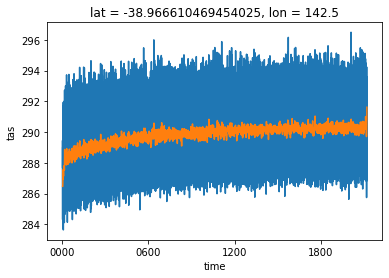

In [57]:
quadco2.sel(lat = -38, lon = 144, method = 'nearest').tas.plot()
quadco2_yearmean.sel(lat = -38, lon = 144, method = 'nearest').tas.plot()

# Global Mean

## Anomlies

In [58]:
quadco2_anom = (quadco2_yearmean - control_climatology).to_array()

In [59]:
quadco2_anom_smean = sn.space_mean(quadco2_anom).squeeze()

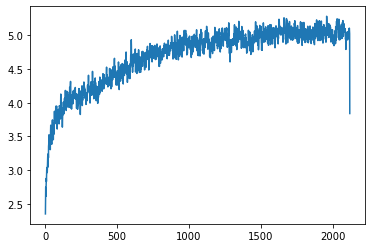

In [60]:
plt.plot(quadco2_anom_smean.values)

## Singal to Noise

In [61]:
quadco2_anom_smean = quadco2_anom_smean.load()

In [62]:
roll_period = 61

In [63]:
quad_sn, signal, noise, loess, loess_detrend = sn.sn_grad_loess(quadco2_anom_smean, 
                                                                roll_period = roll_period, unit  = 'Y',
                                                                return_all = 1)

In [64]:
quad_sn

<xarray.DataArray 'S/N' (time: 2061)>
array([ 8.74884769,  9.20682422,  9.16149839, ..., -1.39727191,
       -1.60788888, -1.3783691 ])
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 2061-12-31 00:00:00
    variable  <U3 'tas'

## Exceenance Instance
This is where the model run is condidsered unstable. 

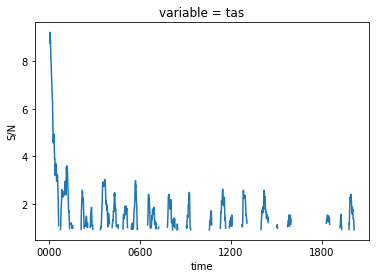

In [65]:
quad_sn.where(quad_sn > stable_bound).plot()

In [66]:
data = quad_sn.where(quad_sn > stable_bound).values
time = quad_sn.where(quad_sn > stable_bound).time.values

In [67]:
consec_start, consec_len = sn.consecutive_counter(data, time)

In [68]:
len(consec_start), len(consec_len)

(32, 32)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


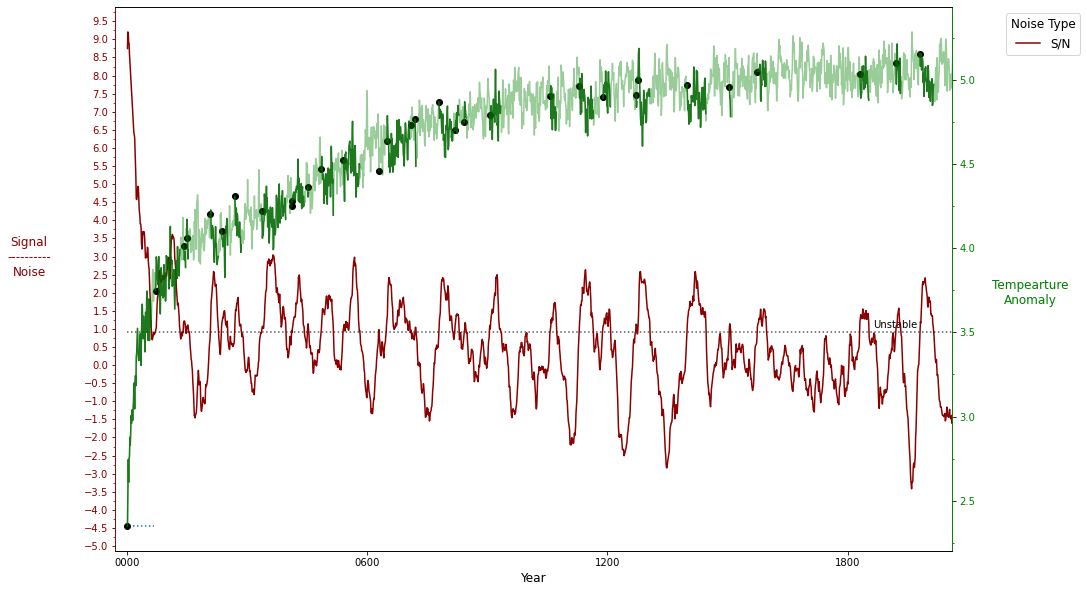

In [69]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

time =  quad_sn.time.values

ax.plot(time, quad_sn, label = 'S/N', c = 'darkred', zorder = 100000)

c0 = plt.gca().lines[0].get_color()
ax.tick_params(axis = 'y', labelcolor = c0)
ax.set_ylabel('Signal\n----------\nNoise', fontsize = 12, color = c0, rotation = 0, labelpad = 55);

leg = ax.legend(ncol = 1, fontsize = 12, bbox_to_anchor = [1.16, 1])
leg.set_title('Noise Type')
leg.get_title().set_fontsize('12')

ax.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.25))

# Second y-axis: the temperature anomalies.
ax2 = ax.twinx()

ax2.plot(quadco2_anom_smean.time.values, quadco2_anom_smean.values,
         color = 'green', alpha = 0.4, label  = 'Temp Anomaly')

ax2.plot(
    quadco2_anom_smean.where(quad_sn > stable_bound).time.values,
    quadco2_anom_smean.where(quad_sn > stable_bound).values, color = 'darkgreen',
    alpha = 0.8
    )


for start in consec_start:
    ax2.scatter(start, quadco2_anom_smean.sel(time = start).values,color = 'k')

c1 = plt.gca().lines[0].get_color()
ax2.tick_params(axis = 'y', labelcolor = c1)
ax2.spines['right'].set_color(c1)
ax2.spines['left'].set_color(c0)
ax.spines['right'].set_color(c1)
ax.spines['left'].set_color(c0)


ax2.set_ylabel('Tempearture\nAnomaly', fontsize = 12, color = c1, rotation = 0, labelpad = 55);
ax2.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.25))

ax2.set_xlim([time[0] - pd.to_timedelta('30Y'), time[-1]])

ax.set_xlabel('Year', fontsize = 12);

ax.plot([time[0], time[-1]],[stable_bound, stable_bound], color = 'k', linestyle = ':', alpha = 0.65)

ANNOTATE_X = -200
ax.annotate('Unstable', xy = (time[ANNOTATE_X], stable_bound + 0.1), ha = 'left');
ax_ylim = ax.get_ylim()
ax.plot([time[5], time[roll_period + 5]], [ax_ylim[0] - 0.4, ax_ylim[0] -0.4], linestyle = ':')

# ax.grid(which = 'major', axis = 'both', linestyle = ':', alpha = 0.5, zorder = -100)
# ax.set_title(f'BEST Signal/Noise and Temperature Anomaly ({ROLL_PERIOD/MONTHS_IN_YEAR}Y Window)', size = 15

# Applying to Multiple GridCells

In [ ]:
quadco2_anom = quadco2_anom.squeeze()

In [ ]:
quadco2_anom

In [ ]:
quadco2_anom = quadco2_anom.chunk({'time':120})

In [ ]:
quadco2_anom 

In [ ]:
quad_sn_grid  = sn.sn_grad_loess(quadco2_anom, roll_period = roll_period, unit  = 'Y')

In [ ]:
quad_sn_grid 

# Old Consecutive

In [ ]:
quad_sn_unstable = quad_sn.where(quad_sn > stable_bound, drop = True)

In [ ]:
import datetime

In [ ]:
expected_time_diff = datetime.timedelta(days=365)

In [ ]:
quad_sn_unstable.time.values[1] - quad_sn_unstable.time.values[0]

In [ ]:
consec = 1
consec_start = []
consec_len = []

for i in np.arange(len(quad_sn_unstable.time.values) - 1):
    
    # Start of consecutive sequence.
    if consec == 1:
        consec_start.append(quad_sn_unstable.time.values[i])
    
    
    # The differentce in timestep.
    diff = quad_sn_unstable.time.values[i + 1] - quad_sn_unstable.time.values[i]
    
    # If the time is expected, e.g. they are next to each other they are consecutive
    if diff == expected_time_diff:
        consec += 1
    else:

        consec_len.append(consec)
        consec = 1